## Classification Project


* Goal:

        ** Discover drivers of churn based off select cartegories present in the telco dataset
        ** Model and test to verify which modeling style works best and gives us a most favorable outcome

# Imports

In [1]:
# All the imports
import acquire as a
import prepare as p
# tabular manipulation
import numpy as np
import pandas as pd
# ML stuff:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, \
export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Acquire

* Data acquired from CodeUp MySQL server
* It contained 7043 rows and 23 columns before cleaning
* Each column represents tracked customer data

In [2]:
#obtaining data
telco = a.get_telco_data()

this file exists, reading from csv


# Prepare

**Prepare Actions:**
* Removed columns that did not contain useful information
* Renamed columns to promote readability
* Checked for nulls and invalid types in the data
* Checked that column data types were appropriate
* Removed white space from values in object columns
* Added Target column 'churn' indicating whether our selected categories have significance influence
* Encoded categorical variables
* Split data into train, validate and test (approx. 60/40 then 50/50), stratifying on 'churn'
* Scaled continuous variable
* Outliers have not been removed for this iteration of the project

In [3]:
#prepping the data
telco = p.prep_telco(telco)

#adjusting for monthly_charges having invalid data types
telco.monthly_charges.isna()

#fixing the internet service type column
telco['internet_service_type'] = telco['internet_service_type'].fillna('None')

# replaces values in the total charges column with a blank space to 0.0
telco.total_charges = telco.total_charges.str.replace(' ','0.0')

# changes total_charges to a float instead of an object
telco['total_charges'] = (telco.total_charges + '0').astype(float)

#splitting data into train/val/test
telco_train, telco_val, telco_test = p.splitting_data(telco, 'churn')

#encoding split data so that we can use encoded columns with binary outputs
train_encode, val_encode, test_encode = p.preprocess_telco(telco_train,telco_val,telco_test)

#fixing the customer id column for modeling later
train_encode = train_encode.set_index(['customer_id'])
val_encode = val_encode.set_index(['customer_id'])
test_encode = test_encode.set_index(['customer_id'])

#X and y values for train
X_train, y_train = train_encode.drop(columns='churn_Yes'), \
train_encode.churn_Yes

#X and y values for validate
X_val, y_val = val_encode.drop(columns='churn_Yes'), \
val_encode.churn_Yes

#X and y values for test
X_test, y_test = test_encode.drop(columns='churn_Yes'), \
test_encode.churn_Yes

## Quick look at what our data looks like and summary of statistics 

In [4]:
train_encode.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,multiple_lines_No phone service,multiple_lines_Yes,...,streaming_movies_Yes,paperless_billing_Yes,churn_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
customer_id,,,,,,,,,,,,,,,,,,,,,
8775-CEBBJ,0,9,44,403.35,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
0336-KXKFK,0,72,61,4390.25,1,0,0,0,1,0,...,1,1,0,0,1,0,0,1,0,0
1383-EZRWL,0,7,20,164.85,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
0311-UNPFF,0,26,88,2274.35,0,0,0,1,0,0,...,1,1,1,0,0,1,0,0,0,0
3640-PHQXK,0,31,89,2806.90,0,0,0,1,0,1,...,1,1,1,0,0,1,0,0,1,0


In [5]:
train_encode.dtypes

senior_citizen                             int64
tenure                                     int64
monthly_charges                            int64
total_charges                            float64
gender_Male                                int64
partner_Yes                                int64
dependents_Yes                             int64
phone_service_Yes                          int64
multiple_lines_No phone service            int64
multiple_lines_Yes                         int64
online_security_No internet service        int64
online_security_Yes                        int64
online_backup_No internet service          int64
online_backup_Yes                          int64
device_protection_No internet service      int64
device_protection_Yes                      int64
tech_support_No internet service           int64
tech_support_Yes                           int64
streaming_tv_No internet service           int64
streaming_tv_Yes                           int64
streaming_movies_No 

## EXPLORE

In [7]:
#Understanding baseline and setting alpha
baseline_percentage = (telco.churn == "No").mean()
print(f'The baseline of churn is {baseline_percentage}')
#setting the alpha
α = 0.05

The baseline of churn is 0.7346301292063041


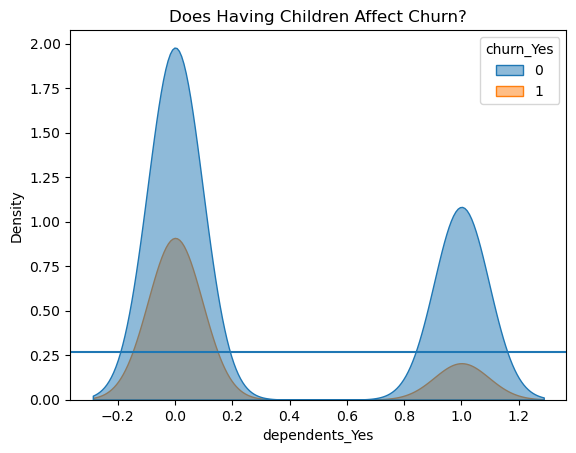

In [19]:
sns.kdeplot(data=train_encode, x='dependents_Yes', hue='churn_Yes', fill=True, alpha=.5)
plt.title("Does Having Children Affect Churn?")
plt.axhline(population_churn, label="Population Churn Rate")
plt.show()

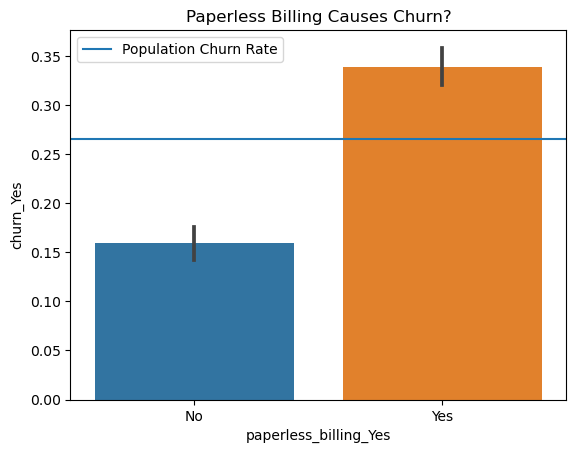

In [20]:
sns.barplot(data=train_encode, x='paperless_billing_Yes', y='churn_Yes')
plt.title("Paperless Billing Causes Churn?")
plt.axhline(population_churn, label="Population Churn Rate")
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.legend()
plt.show()

> Onto the statistical tests, utilizing chi^2 tests for these features since they're all bivariate 

In [33]:
# Let's run a chi squared to compare proportions, to have more confidence
𝐻0  = "there is NO relationship between gender and churn"
𝐻𝑎  = "there is a relationship between gender and churn"

# Setup a crosstab of observed survival to pclass
observed_gender = pd.crosstab(train_encode.churn_Yes, train_encode.gender_Male)

chi2, p, degf, expected = stats.chi2_contingency(observed_gender)

if p < α:
    print(f"Reject the null hypothesis that, {𝐻0}")
    print(f"Sufficient evidence to move forward understanding that, {𝐻𝑎}")
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Fail to reject the null
Insufficient evidence to reject the null


0.34677390607565795

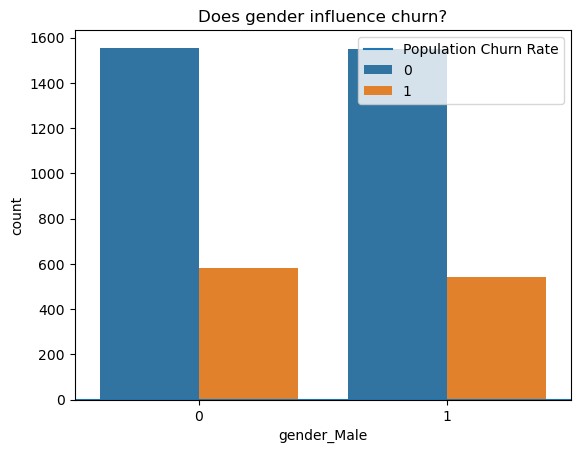

In [25]:
#building plots for my selected features
sns.countplot(data=train_encode, x='gender_Male', hue='churn_Yes')
plt.title("Does gender influence churn?")
population_churn = train_encode.churn_Yes.mean()
plt.axhline(population_churn, label="Population Churn Rate")
plt.legend()
plt.show()

Gender not appearing to influence churn

In [30]:
𝐻0  = "there is NO relationship between having a partner and churn"
𝐻𝑎  = "there is a relationship between having a parnter and churn"

# Setup a crosstab of observed survival to pclass
observed_partner = pd.crosstab(train_encode.churn_Yes, train_encode.partner_Yes)

chi2, p, degf, expected = stats.chi2_contingency(observed_partner)

if p < α:
    print(f"Reject the null hypothesis that, {𝐻0}")
    print(f"Sufficient evidence to move forward understanding that, {𝐻𝑎}")
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that, there is NO relationship between having a partner and churn
Sufficient evidence to move forward understanding that, there is a relationship between having a parnter and churn


3.3117883244850396e-24

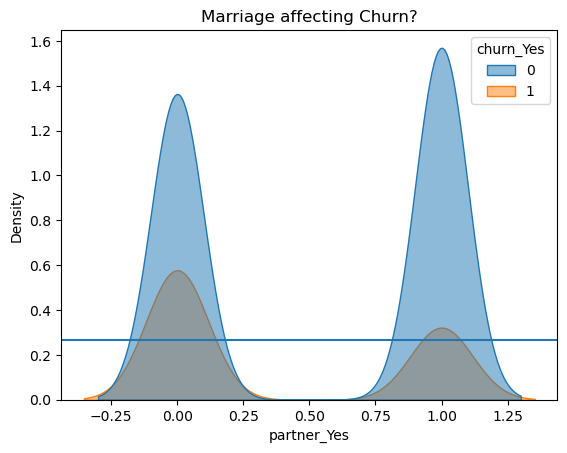

In [26]:
sns.kdeplot(data=train_encode, x='partner_Yes', hue='churn_Yes', fill=True, alpha=.5)
plt.title("Marriage affecting Churn?")
plt.axhline(population_churn, label="Population Churn Rate")
plt.show()

Partner is observed to influence churn

In [34]:
𝐻0 = "there is NO relationship between having dependents and churn"
𝐻𝑎 = "there is a relationship between having dependents and churn"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train_encode.churn_Yes, train_encode.dependents_Yes)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < α:
    print(f"Reject the null hypothesis that, {𝐻0}")
    print(f"Sufficient evidence to move forward understanding that, {𝐻𝑎}")
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p

Reject the null hypothesis that, there is NO relationship between having dependents and churn
Sufficient evidence to move forward understanding that, there is a relationship between having dependents and churn


6.84215803296947e-26

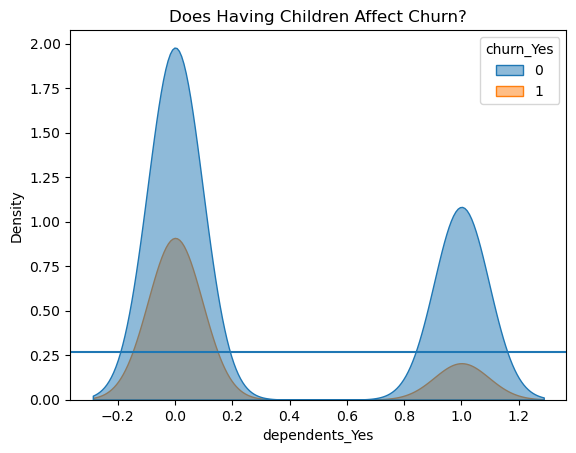

In [35]:
sns.kdeplot(data=train_encode, x='dependents_Yes', hue='churn_Yes', fill=True, alpha=.5)
plt.title("Does Having Children Affect Churn?")
plt.axhline(population_churn, label="Population Churn Rate")
plt.show()

Having children is observed to affect churn